
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



# Series temporales  


La columna temporal tiene que ser continua, estar en el índice de nuestro Data Frame y tener una frecuencia (pandas tiene que reconocer que son meses, días o años) (no puede faltar ningún dato)  
  
ST= tendencia + estacionalidad + ciclico + ruido  
EJ de los aviones:  ST= tendencia de aumento de pasajeros + patrón que se repite año a año en un momento dado (aumentan los vuelos en verano) + evento que ocurre durante un periodo de tiempo largo (disminución de pasajeros en el COVID) + cancelaciones masivas por una tormenta o un atentado  

- Nulos  (no se puede imputar con todo sino con los que estén próximos al nulo (Ejemplo de las temperaturas))
- Estandarización (No es necesaria)  
- Tratar los duplicados  
- Asegurarnos que no falte ningun mes, año o día (que sea continuo)  
- Analizar la tendencia o estacionaridad(no hay tendencia) de los datos


In [121]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product

from datetime import datetime
# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

import sys
import os
sys.path.append(os.path.abspath("src"))   
import soporte_preprocesamiento_serie_temporal as f

In [2]:
df=pd.read_csv("datos\Truck_sales.csv", parse_dates=["Month-Year"] ) 
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


Comprobamos si está en datetime

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Month-Year          144 non-null    object
 1   Number_Trucks_Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%b')

Ahora ya lo metemos en el index

In [5]:
df.set_index("Month-Year", inplace=True)

df.index.name= "Date"
df.head()

,Number_Trucks_Sold
Date,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


In [6]:
df_copia=df.copy()

### EDA

Creamos columnas de mes y año para poder visualizar

In [7]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Number_Trucks_Sold  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [8]:
df_copia["month"]= df_copia.index.month_name()
df_copia["year"]= df_copia.index.year

In [9]:
df_copia.head()

,Number_Trucks_Sold,month,year
Date,,,
2003-01-01,155,January,2003
2003-02-01,173,February,2003
2003-03-01,204,March,2003
2003-04-01,219,April,2003
2003-05-01,223,May,2003


In [10]:
f.exploracion_dataframe(df_copia, "Number_Trucks_Sold")

El número de datos es 144 y el de columnas es 3

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Number_Trucks_Sold,int64
month,object
year,int32



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna MONTH tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 12 categorías (5/12)


,count
month,
January,12
February,12
March,12
April,12
May,12



----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
Number_Trucks_Sold,144.0,428.729167,188.633037,152.0,273.50,406.0,560.25,958.0
year,144.0,2008.500000,3.464102,2003.0,2005.75,2008.5,2011.25,2014.0



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
month,144,12,January,12



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Number_Trucks_Sold  144 non-null    int64 
 1   month               144 non-null    object
 2   year                144 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.9+ KB


None

In [11]:
df_copia.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq=None)

Si nos Fijamos pone freq=None entonces pandas no nos está detectando que es una frecuencia asique hay que decirlo

In [12]:
df_copia= df_copia.asfreq("MS")   #MS es formato mes año

In [13]:
df_copia.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq='MS')

Para comprobar si nuestras fechas son continuas lo vamos a comparar con un rango que generamos donde no faltan fechas

In [14]:
fecha_completa= pd.date_range(start=df_copia.index.min(), end=df_copia.index.max(), freq="MS")
fecha_completa

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

Ya hacemos la comparación

In [15]:
# mes_anio_completo= fecha_completa.index.to_period("M")        #Esto es si fecha completa a pesar de poner freq=MS sigue poniendo los días
# mes_anio_actual= df_copia.index.to_period("M")
# mes_anio_completo.differnce(mes_anio_actual)

mes_anio_completo= fecha_completa
mes_anio_actual= df_copia.index
mes_anio_completo.difference(mes_anio_actual)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [16]:
df.sort_index(inplace=True)

In [17]:
df.head()

,Number_Trucks_Sold
Date,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


GRAFICAMOS

<Axes: xlabel='Date', ylabel='Number_Trucks_Sold'>

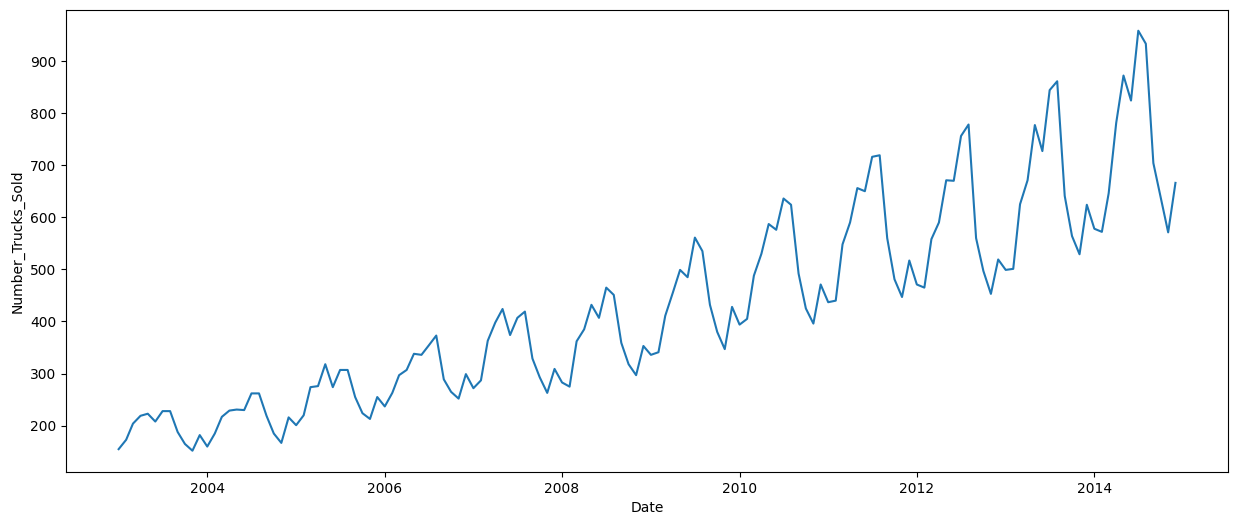

In [18]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df_copia.index, y=df_copia["Number_Trucks_Sold"] ,data=df_copia)

Observamos que los datos son NO Estacionarios (es decir, tienen tendencia)  


<Axes: xlabel='month', ylabel='Number_Trucks_Sold'>

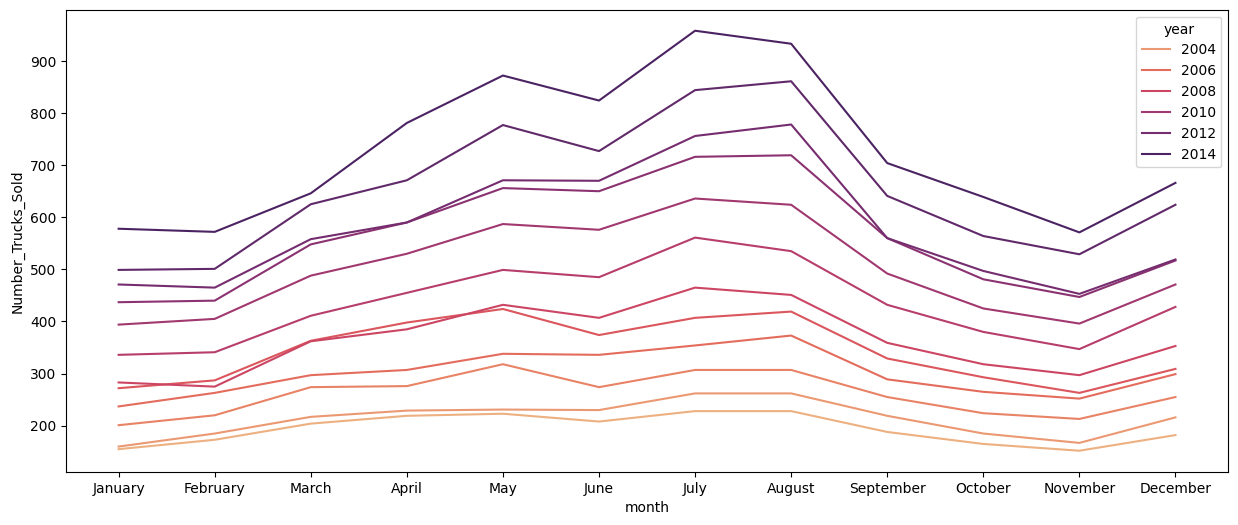

In [19]:
plt.figure(figsize=(15,6))
sns.lineplot(x="month", y= "Number_Trucks_Sold",hue="year", data= df_copia, palette="flare")

Observamos que los datos son NO Estacionarios (es decir, tienen tendencia) pero sobre todo este gráfico sirve para observar la estacionalidad  
Parece que nuestros datos también son estacionales.   

Esto es para graficar todo a la vez

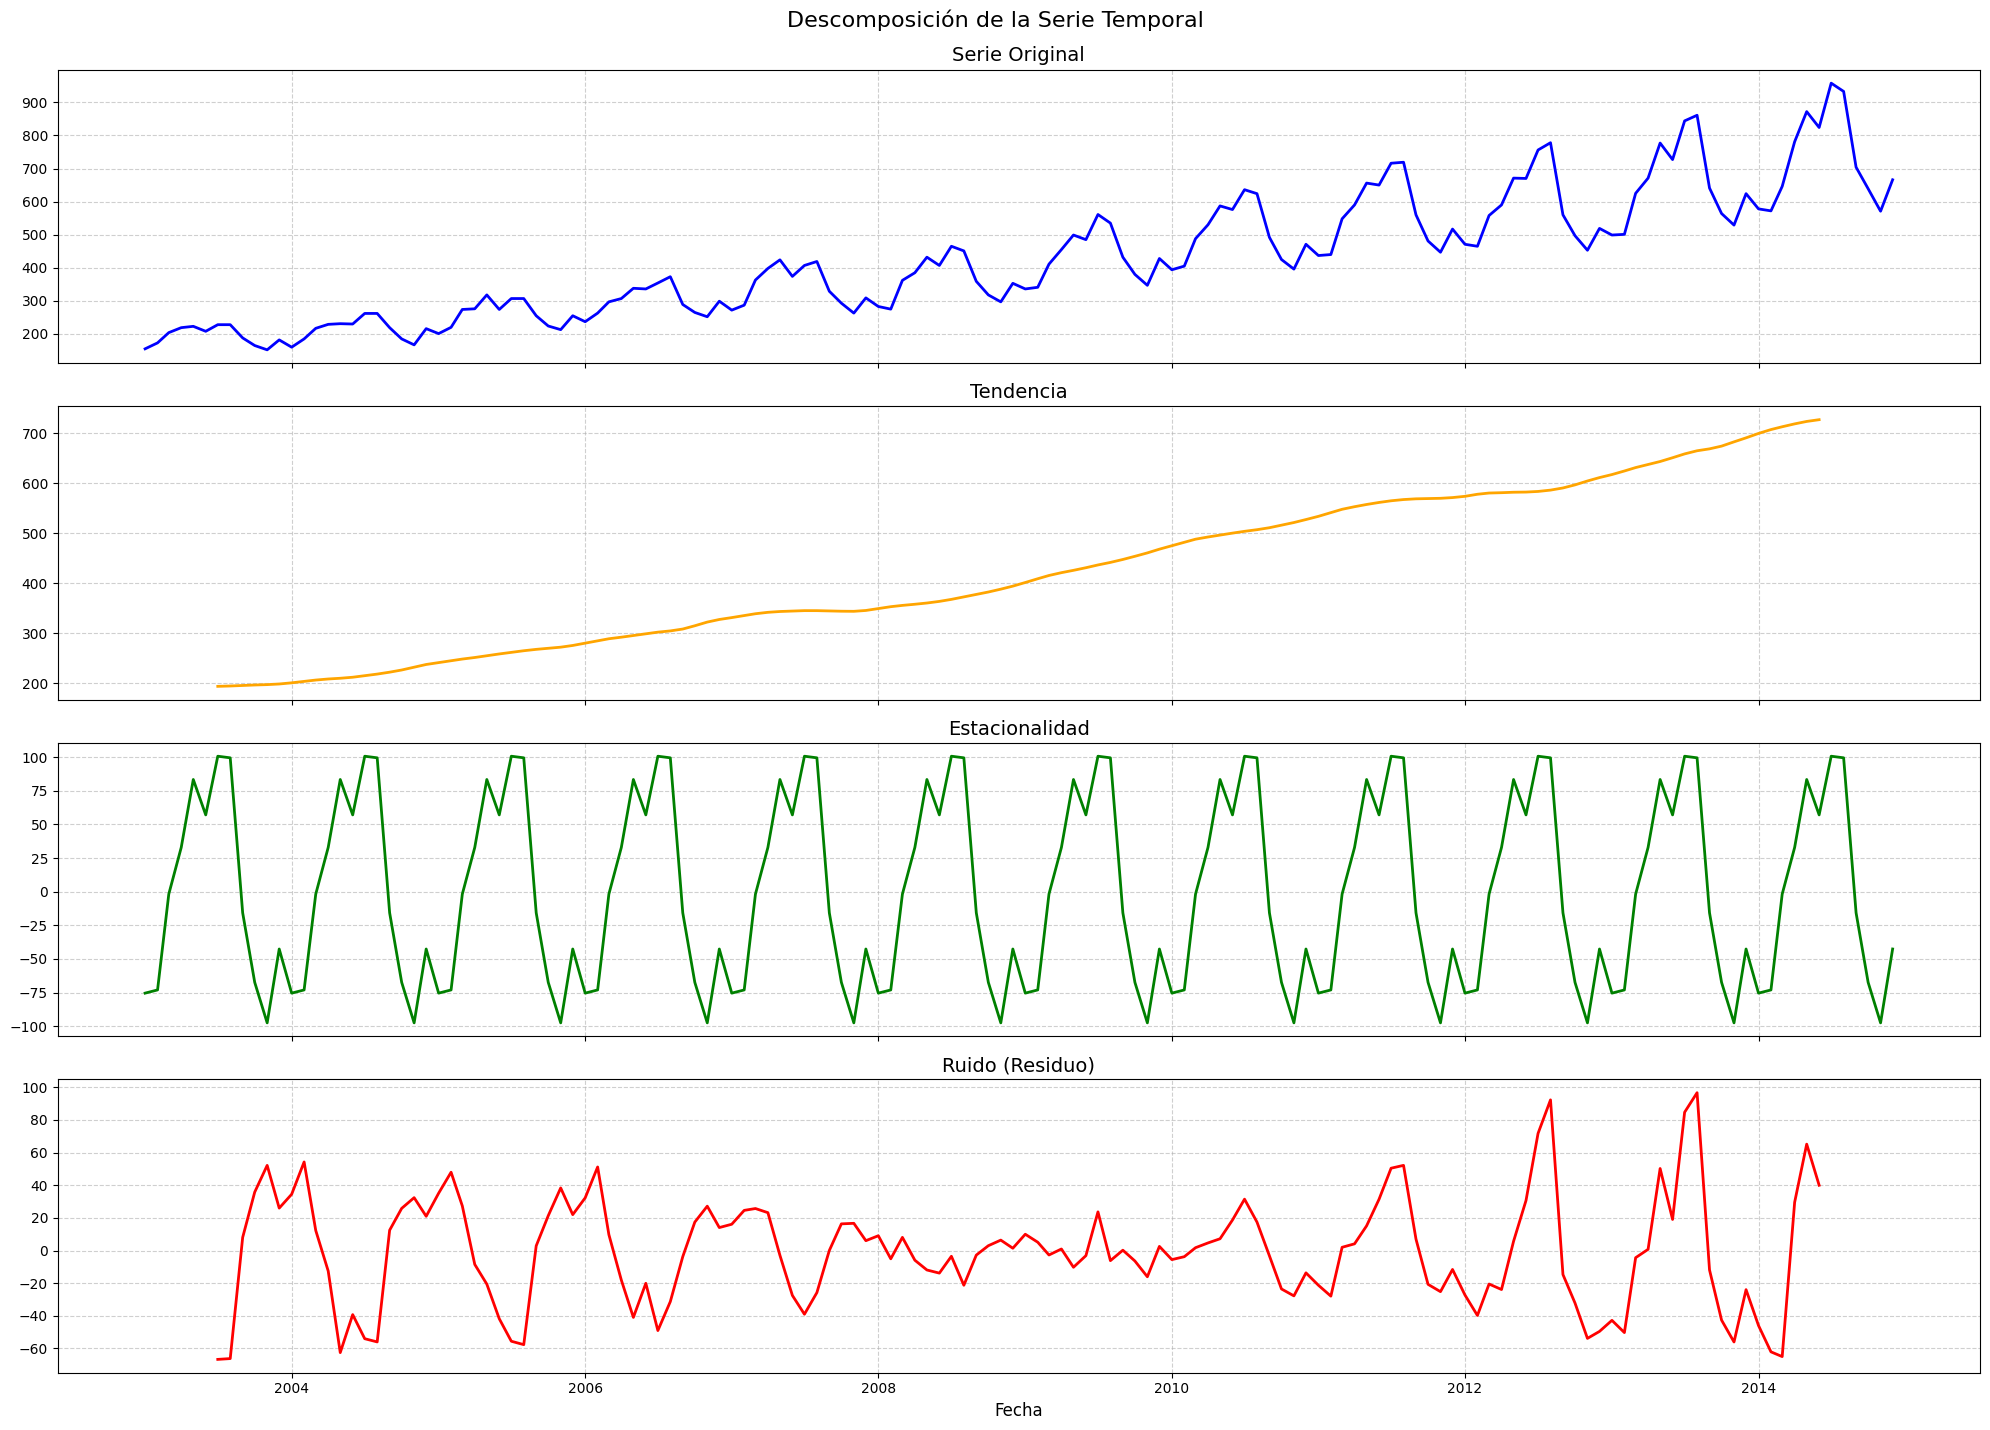

In [20]:
decomposition = seasonal_decompose(df["Number_Trucks_Sold"], model='additive', period=12)

# Crear figura y subplots
fig, axes = plt.subplots(4, 1, figsize= (20, 15), sharex=True)

# Serie original
axes[0].plot(df["Number_Trucks_Sold"], color="blue", linewidth=2)
axes[0].set_title("Serie Original", fontsize=14)
axes[0].grid(visible=True, linestyle="--", alpha=0.6)

# Tendencia
axes[1].plot(decomposition.trend, color="orange", linewidth=2)
axes[1].set_title("Tendencia", fontsize=14)
axes[1].grid(visible=True, linestyle="--", alpha=0.6)

# Estacionalidad
axes[2].plot(decomposition.seasonal, color="green", linewidth=2)
axes[2].set_title("Estacionalidad", fontsize=14)
axes[2].grid(visible=True, linestyle="--", alpha=0.6)

# Ruido
axes[3].plot(decomposition.resid, color="red", linewidth=2)
axes[3].set_title("Ruido (Residuo)", fontsize=14)
axes[3].grid(visible=True, linestyle="--", alpha=0.6)

# Ajustar diseño
plt.suptitle("Descomposición de la Serie Temporal", fontsize=16, y=0.95)
plt.xlabel("Fecha", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Compruebo la Estacionaridad o No estacionaridad analíticamente**

In [21]:

result = adfuller(df["Number_Trucks_Sold"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Valores Críticos:")
for key, value in result[4].items():
    print(f"{key}: {value}")
if result[1] < 0.05:
    print("Rechazamos la hipótesis nula. La serie es estacionaria.")
else:
    print("No podemos rechazar la hipótesis nula. La serie NO es estacionaria.")

ADF Statistic: 1.1158932574252591
p-value: 0.9953500083802601
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


### **MODELOS DE SERIES TEMPORALES:**  
  
**SARIMA(X)**  (No funcionan con Tendencias por ello se transforman los datos para que no tengan tendencia (parámetro "d"))
- Cuando los datos sean *estacionales* y haya *tendencia*  
  
  AUTOCORRELACIÓN (El dato siguiente dependerá del anterior)
- Parámetros:  
    - p: nº de valores del pasado que voy a usar para predecir el futuro  SALE DE LA AUTOCORRELACIÓN PARCIAL
    - d(diferenciación): 1 *(Si los patrones de tendencia son muy leves/suaves (usa exponenciales o logaritmicas dependiendo de los datos))* o 2 *(Si los patrones de tendencia son muy claros/abruptos (usa box-post))*
    - q: nº de errores del pasado que vamos a usar para corregir las predicciones del futuro   SALE DE LA AUTOCORRELACIÓN
  
**ARIMA**  
- Cuando los datos sean *NO estacionales* y haya o no *tendencia*  
  
- Parámetros:  
    - p
    - d
    - q  

En nuestro caso concreto usamos el SARIMA

Esta gráfica nos permite identificar patrones de correlaciones entre los datos   
  
**También nos sirve para sacar el parámetro Q**  

<Figure size 1000x3000 with 0 Axes>

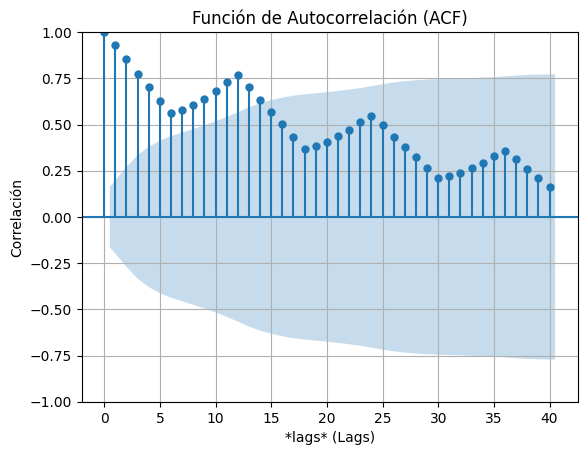

In [22]:
# GRAFICO DE LA AUTOCORRELACIÓN
plt.figure(figsize=(10,30))
plot_acf(df, lags=40)  
plt.title("Función de Autocorrelación (ACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación")
plt.grid();

***Este gráfico nos muestra como se van correlacionando los datos empezando por si mismo (Ej enero de 2020 va bajando su correlacion con los siguientes meses del año hasta que llega Enero de 2021 que sube la correlación porque es el mismo mes (estos picos no confirman la estacionalidad pero está más bajo por que tiene tendencia))***    
En el lag 1 compara las correlaciones de un salto enero con febrero, febrero con marzo etc  
En el lag 2 compara las correlaciones de dos saltos enero con marzo, febrero con abril etc  
En el lag 3 compara las correlaciones de tres saltos enero con abril, febrero con mayo etc   
....  
En el lag 12 compara las correlaciones de doce saltos enero 2020 con enero 2021, febrero 2020 con febrero 2021 etc (Estos son los picos)    
  

De aquí sacamos que el parámetro Q=12 porque es el periodo estacional (auqnue no sea el último significativo)   

***ESTE GRÁFICO SIRVE PARA DETERMINAR EL PARÁMETRO P***

las sombras son los intervalos de confianzas de que sean 0 es decir si el punto (correlación) está dentro del rango significa que podría ser 0 y por ello no sería sigificativa

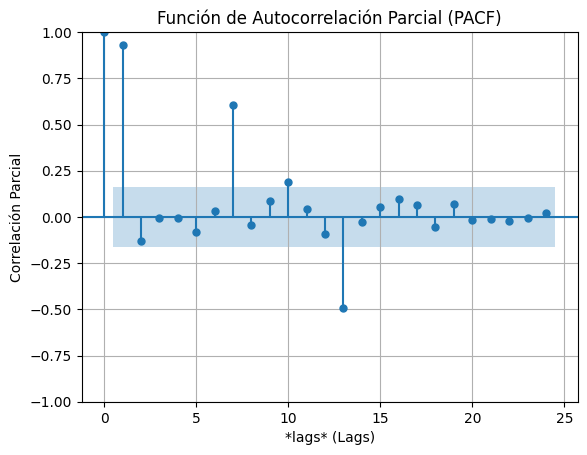

In [23]:
# Graficar la autocorrelación parcial
plot_pacf(df, lags=24, method='ywm')  # Cambia 'method' según tu versión
plt.title("Función de Autocorrelación Parcial (PACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación Parcial")
plt.grid()
plt.show()

Este compara los lags pero en vez de en el lag 12 comparar solo enero 2020 y enero 2021, tiene en cuenta todos los meses que hay entre medias  
  
De aquí sacamos que el parámetro P=1 porque es el último lag consecutivo que es significativo

#### Ahora vamos a separar en Train y Test para entrenar el modelo

In [24]:
datos_en_test=int(np.round(df.shape[0]*0.2, 0))
y_train= df.iloc[:-datos_en_test]
y_test= df.iloc[-datos_en_test:]


El arima no tiene el parametro de estacionalidad

In [25]:
ps= range(4)
qs= range(11)

combinaciones=list(product(ps,qs))


Esto es para sacar nuestro mejor modelo

In [26]:
resultados={"q": [],
            "p": [],
            "rmse": []}

for p, q in combinaciones:

    modelo_sarima= SARIMAX( y_train, 
                        order= (p,1,q),                    #Se pone la p, la d y la q
                        seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                                
    pred_y_test= modelo_sarima.predict(start= len(y_train), end=len(df)-1)                   # Esto es para decir el número de datos que quieres q te prediga que es basicamente el número de datos que hay en y_test
    rmse= np.sqrt(mean_squared_error(pred_y_test,y_test))   
    resultados["p"].append(p) 
    resultados["q"].append(q) 
    resultados["rmse"].append(rmse)           

pd.DataFrame(resultados).sort_values(by="rmse", ascending=True).head(6)       

,q,p,rmse
14,3,1,43.018390
34,1,3,43.348241
18,7,1,43.925534
9,9,0,43.927920
19,8,1,43.995391
17,6,1,44.002473


Meto aquí el mejor modelo que he seleccionado

In [27]:
#Aquí se meten los parametros de nuestro mejor modelo

modelo_sarima= SARIMAX( y_train, 
                    order= (1,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y_test= modelo_sarima.predict(start= len(y_train), end=len(df)-1)   


y_test["predichos"]= pred_y_test.astype(int) 



In [28]:
y_test.head()

,Number_Trucks_Sold,predichos
Date,,
2012-08-01,778,758
2012-09-01,560,606
2012-10-01,497,528
2012-11-01,453,495
2012-12-01,519,566


PLOT PARA COMPARAR PREDICHOS CON REALES

<Axes: xlabel='Date', ylabel='Number_Trucks_Sold'>

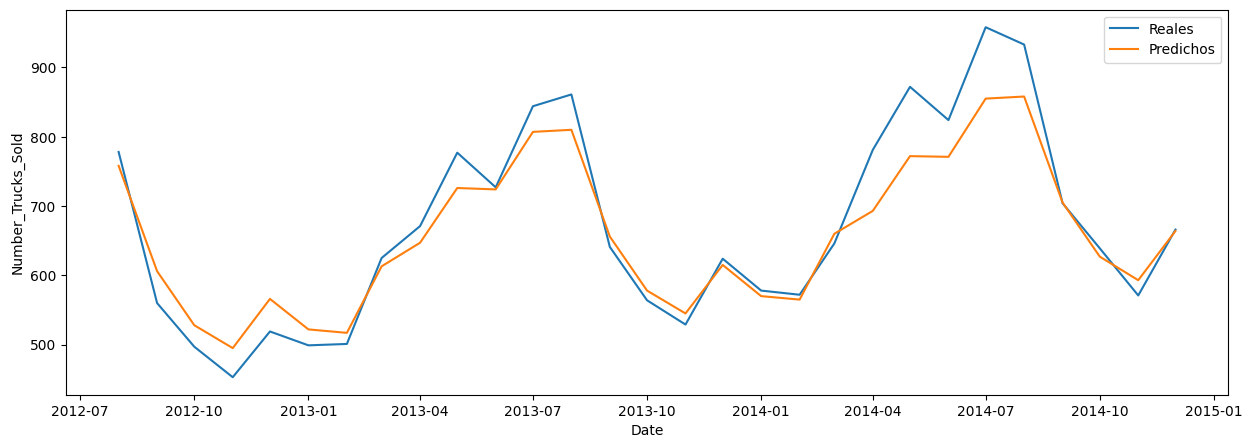

In [29]:
plt.figure(figsize=(15,5))
sns.lineplot(x=y_test.index, y = "Number_Trucks_Sold", data= y_test,label="Reales", legend=True)
sns.lineplot(x=y_test.index, y = "predichos", data= y_test,label="Predichos")


AHORA HAY QUE ENTRENAR EL MODELO CON TODO Y DECIRLE QUE ME PREDIGA EL Nº DE CAMIONES VENDIDOS EN LOS SIGUIENTES 30 MESES 

In [30]:
modelo_sarima= SARIMAX( df, 
                    order= (1,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df), end=len(df)+30)   #pongo el más 30 porque son los que quiero predecir


pred_y= pred_y.astype(int)

In [31]:
datos_predichos=pd.DataFrame(pred_y)

In [32]:
datos_predichos.head()

,predicted_mean
2015-01-01,625
2015-02-01,621
2015-03-01,705
2015-04-01,838
2015-05-01,932


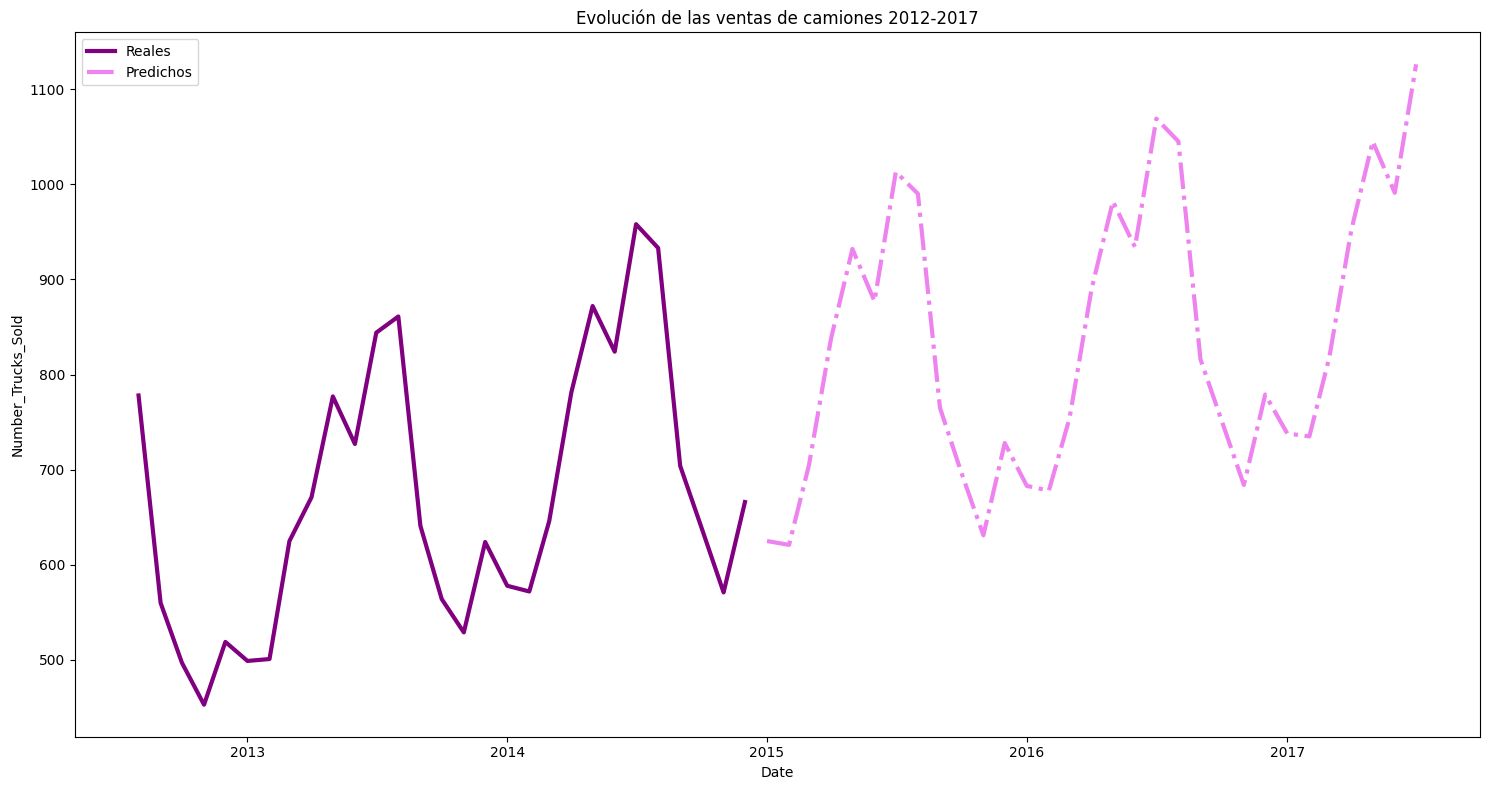

In [33]:

plt.figure(figsize=(15,8))
sns.lineplot(x=y_test.index, y = "Number_Trucks_Sold", data= y_test, color = "purple", linewidth=3,label="Reales", legend=True)
sns.lineplot(x=datos_predichos.index, y = "predicted_mean", data= datos_predichos, color = "violet", linewidth=3, linestyle='-.',label="Predichos")
plt.title("Evolución de las ventas de camiones 2012-2017")
plt.tight_layout();

PROBAR AHORA CON 70%

In [34]:
datos_en_test=int(np.round(df.shape[0]*0.3, 0))
y_train= df.iloc[:-datos_en_test]
y_test= df.iloc[-datos_en_test:]


El arima no tiene el parametro de estacionalidad

In [37]:
ps= range(4)
qs= range(12)

combinaciones=list(product(ps,qs))


Esto es para sacar nuestro mejor modelo

In [38]:
resultados={"q": [],
            "p": [],
            "rmse": []}

for p, q in combinaciones:

    modelo_sarima= SARIMAX( y_train, 
                        order= (p,1,q),                    #Se pone la p, la d y la q
                        seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                                
    pred_y_test= modelo_sarima.predict(start= len(y_train), end=len(df)-1)                   # Esto es para decir el número de datos que quieres q te prediga que es basicamente el número de datos que hay en y_test
    rmse= np.sqrt(mean_squared_error(pred_y_test,y_test))   
    resultados["p"].append(p) 
    resultados["q"].append(q) 
    resultados["rmse"].append(rmse)           

pd.DataFrame(resultados).sort_values(by="rmse", ascending=True).head(6)       

,q,p,rmse
47,11,3,35.185200
46,10,3,36.445534
44,8,3,39.506297
45,9,3,39.808628
39,3,3,41.145610
42,6,3,41.246061


Meto aquí el mejor modelo que he seleccionado

In [53]:
#Aquí se meten los parametros de nuestro mejor modelo

modelo_sarima= SARIMAX( y_train, 
                    order= (3,1,11),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y_test= modelo_sarima.predict(start= len(y_train), end=len(df)-1)   


y_test["predichos"]= pred_y_test.astype(int) 



In [54]:
y_test.head()

,Number_Trucks_Sold,predichos
Date,,
2011-06-01,650,642
2011-07-01,716,708
2011-08-01,719,690
2011-09-01,560,556
2011-10-01,481,483


PLOT PARA COMPARAR PREDICHOS CON REALES

<Axes: xlabel='Date', ylabel='Number_Trucks_Sold'>

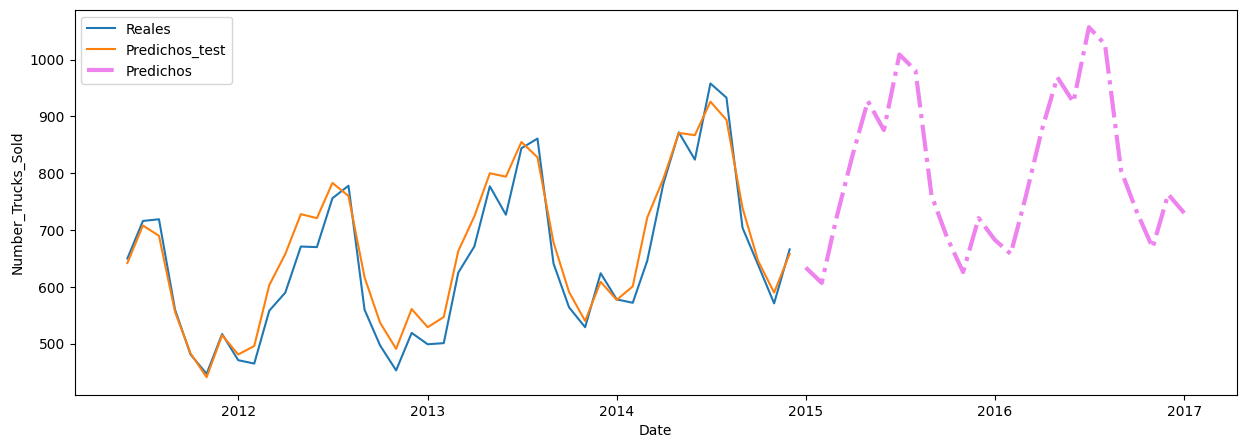

In [55]:
plt.figure(figsize=(15,5))
sns.lineplot(x=y_test.index, y = "Number_Trucks_Sold", data= y_test,label="Reales", legend=True)
sns.lineplot(x=y_test.index, y = "predichos", data= y_test,label="Predichos_test")
sns.lineplot(x=datos_predichos.index, y = "predicted_mean", data= datos_predichos, color = "violet", linewidth=3, linestyle='-.', label="Predichos" )


AHORA HAY QUE ENTRENAR EL MODELO CON TODO Y DECIRLE QUE ME PREDIGA EL Nº DE CAMIONES VENDIDOS EN LOS SIGUIENTES 30 MESES 

In [56]:
modelo_sarima= SARIMAX( df, 
                    order= (3,1,10),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit(disp=False)   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df), end=len(df)+24)   #pongo el más 24 porque son los que quiero predecir


pred_y= pred_y.astype(int)

In [57]:
datos_predichos=pd.DataFrame(pred_y)

In [58]:
datos_predichos.head()

,predicted_mean
2015-01-01,634
2015-02-01,607
2015-03-01,720
2015-04-01,830
2015-05-01,927


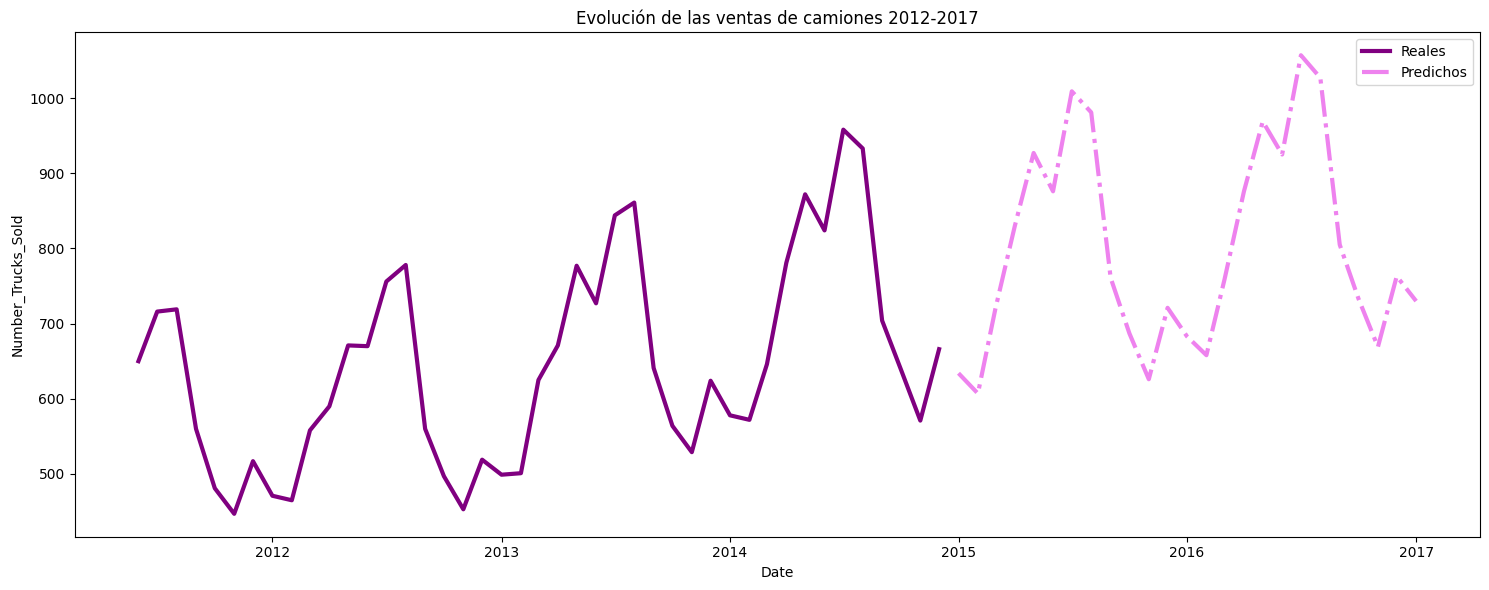

In [59]:

plt.figure(figsize=(15,6))
sns.lineplot(x=y_test.index, y = "Number_Trucks_Sold", data= y_test, color = "purple", linewidth=3,label="Reales", legend=True)
sns.lineplot(x=datos_predichos.index, y = "predicted_mean", data= datos_predichos, color = "violet", linewidth=3, linestyle='-.', label="Predichos" )
plt.title("Evolución de las ventas de camiones 2012-2017")
plt.tight_layout();

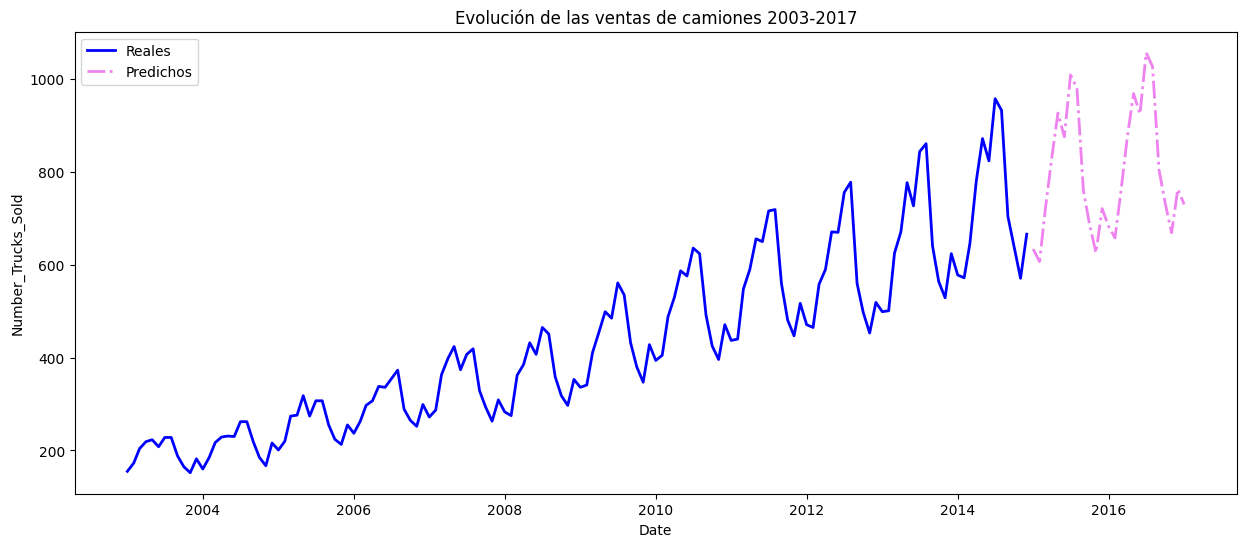

In [60]:
plt.figure(figsize=(15,6))
sns.lineplot(df["Number_Trucks_Sold"], color="blue", linewidth=2, label="Reales", legend=True)
sns.lineplot(x=datos_predichos.index, y = "predicted_mean", data= datos_predichos, color = "violet", linewidth=2, linestyle='-.', label="Predichos" )
plt.title("Evolución de las ventas de camiones 2003-2017");

Observamos como se espera en el próximo año que continúe la tendencia del aumento de camiones vendidos mientras que se mantienen los patrones estacionales dentro de cada año.
  
Las predicciones parecen ser bastante fiables ya que su rmse es de 36 camiones.  

# CON OTRA BASE DE DATOS

In [81]:
df_bb=pd.read_csv("datos\BBVA.csv" ) 
df_bb.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1988-12-15,3.844128,3.857569,3.817246,3.817246,0.041762,1782700
1,1988-12-16,3.817246,3.817246,3.803805,3.803805,0.041615,777400
2,1988-12-19,3.803805,3.803805,3.790364,3.790364,0.041468,411000
3,1988-12-20,3.790364,3.803805,3.790364,3.790364,0.041468,134800
4,1988-12-21,3.790364,3.803805,3.790364,3.803805,0.041615,242600


Comprobamos si está en datetime

In [82]:

df_bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7885 entries, 0 to 7884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7885 non-null   object 
 1   Open       7885 non-null   float64
 2   High       7885 non-null   float64
 3   Low        7885 non-null   float64
 4   Close      7885 non-null   float64
 5   Adj Close  7885 non-null   float64
 6   Volume     7885 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 431.3+ KB


In [83]:
df_bb['Date'] = pd.to_datetime(df_bb['Date'])

In [84]:
df_bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7885 entries, 0 to 7884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7885 non-null   datetime64[ns]
 1   Open       7885 non-null   float64       
 2   High       7885 non-null   float64       
 3   Low        7885 non-null   float64       
 4   Close      7885 non-null   float64       
 5   Adj Close  7885 non-null   float64       
 6   Volume     7885 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 431.3 KB


Ahora ya lo metemos en el index

In [85]:
df_bb.set_index("Date", inplace=True)
df_bb.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1988-12-15,3.844128,3.857569,3.817246,3.817246,0.041762,1782700
1988-12-16,3.817246,3.817246,3.803805,3.803805,0.041615,777400
1988-12-19,3.803805,3.803805,3.790364,3.790364,0.041468,411000
1988-12-20,3.790364,3.803805,3.790364,3.790364,0.041468,134800
1988-12-21,3.790364,3.803805,3.790364,3.803805,0.041615,242600


Creo que solo me interesa predecir el Close y dado que de momento no hemos aprendido otra manera teniendo muchas columnas dropeo las que no son Close

In [86]:
df_bb.drop(columns=["Open",	"High",	"Low",	"Adj Close","Volume"], inplace=True)

In [87]:
dfb_copia=df_bb.copy()

In [88]:
dfb_copia.head()

,Close
Date,
1988-12-15,3.817246
1988-12-16,3.803805
1988-12-19,3.790364
1988-12-20,3.790364
1988-12-21,3.803805


In [90]:
dfb_copia["month"]= dfb_copia.index.month_name()
dfb_copia["year"]= dfb_copia.index.year
dfb_copia["day"]= dfb_copia.index.day

In [91]:
dfb_copia.head()

,Close,month,year,day
Date,,,,
1988-12-15,3.817246,December,1988,15
1988-12-16,3.803805,December,1988,16
1988-12-19,3.790364,December,1988,19
1988-12-20,3.790364,December,1988,20
1988-12-21,3.803805,December,1988,21


In [92]:
f.exploracion_dataframe(dfb_copia, "Close")

El número de datos es 7885 y el de columnas es 4

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Close,float64
month,object
year,int32
day,int32



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna MONTH tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 12 categorías (5/12)


,count
month,
March,699
August,688
October,686
December,663
June,662



----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
Close,7885.0,9.713759,5.635297,2.029592,4.583384,9.16,13.125143,25.384148
year,7885.0,2004.090679,9.039797,1988.000000,1996.000000,2004.00,2012.000000,2020.000000
day,7885.0,15.749144,8.748790,1.000000,8.000000,16.00,23.000000,31.000000



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
month,7885,12,March,699



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7885 entries, 1988-12-15 to 2020-04-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7885 non-null   float64
 1   month   7885 non-null   object 
 2   year    7885 non-null   int32  
 3   day     7885 non-null   int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 246.4+ KB


None

In [93]:
dfb_copia.index

DatetimeIndex(['1988-12-15', '1988-12-16', '1988-12-19', '1988-12-20',
               '1988-12-21', '1988-12-22', '1988-12-23', '1988-12-27',
               '1988-12-28', '1988-12-29',
               ...
               '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
               '2020-03-31', '2020-04-01'],
              dtype='datetime64[ns]', name='Date', length=7885, freq=None)

Si nos Fijamos pone freq=None entonces pandas no nos está detectando que es una frecuencia asique hay que decirlo

In [ ]:
dfb_copia= dfb_copia.asfreq("D")   #D es formato año,mes y año

In [95]:
dfb_copia.index

DatetimeIndex(['1988-12-15', '1988-12-16', '1988-12-17', '1988-12-18',
               '1988-12-19', '1988-12-20', '1988-12-21', '1988-12-22',
               '1988-12-23', '1988-12-24',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01'],
              dtype='datetime64[ns]', name='Date', length=11431, freq='D')

Para comprobar si nuestras fechas son continuas lo vamos a comparar con un rango que generamos donde no faltan fechas

In [96]:
fecha_completa= pd.date_range(start=dfb_copia.index.min(), end=dfb_copia.index.max(), freq="D")
fecha_completa

DatetimeIndex(['1988-12-15', '1988-12-16', '1988-12-17', '1988-12-18',
               '1988-12-19', '1988-12-20', '1988-12-21', '1988-12-22',
               '1988-12-23', '1988-12-24',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01'],
              dtype='datetime64[ns]', length=11431, freq='D')

Ya hacemos la comparación

In [97]:
# mes_anio_completo= fecha_completa.index.to_period("M")        #Esto es si fecha completa a pesar de poner freq=MS sigue poniendo los días
# mes_anio_actual= df_copia.index.to_period("M")
# mes_anio_completo.differnce(mes_anio_actual)

mes_anio_completo= fecha_completa
mes_anio_actual= dfb_copia.index
mes_anio_completo.difference(mes_anio_actual)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [98]:
df_bb.sort_index(inplace=True)

In [99]:
df_bb.head()

,Close
Date,
1988-12-15,3.817246
1988-12-16,3.803805
1988-12-19,3.790364
1988-12-20,3.790364
1988-12-21,3.803805


GRAFICAMOS

<Axes: xlabel='Date', ylabel='Close'>

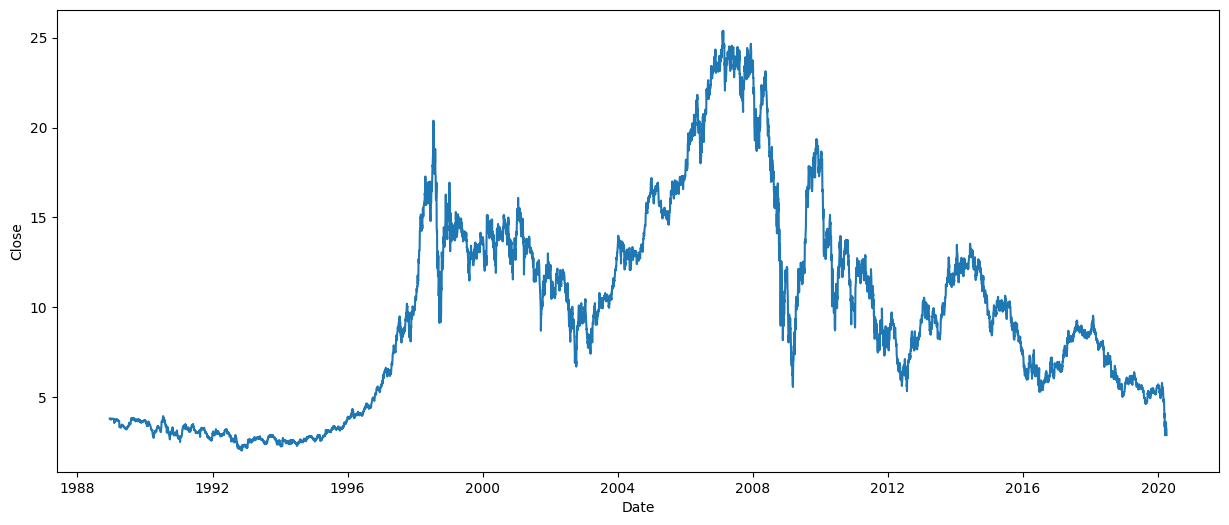

In [100]:
plt.figure(figsize=(15,6))
sns.lineplot(x=dfb_copia.index, y=dfb_copia["Close"] ,data=dfb_copia)

Observamos que los datos son NO Estacionarios (es decir, tienen tendencia)  


Observamos que los datos son NO Estacionarios (es decir, tienen tendencia) pero sobre todo este gráfico sirve para observar la estacionalidad  
Parece que nuestros datos también son estacionales.   

Esto es para graficar todo a la vez

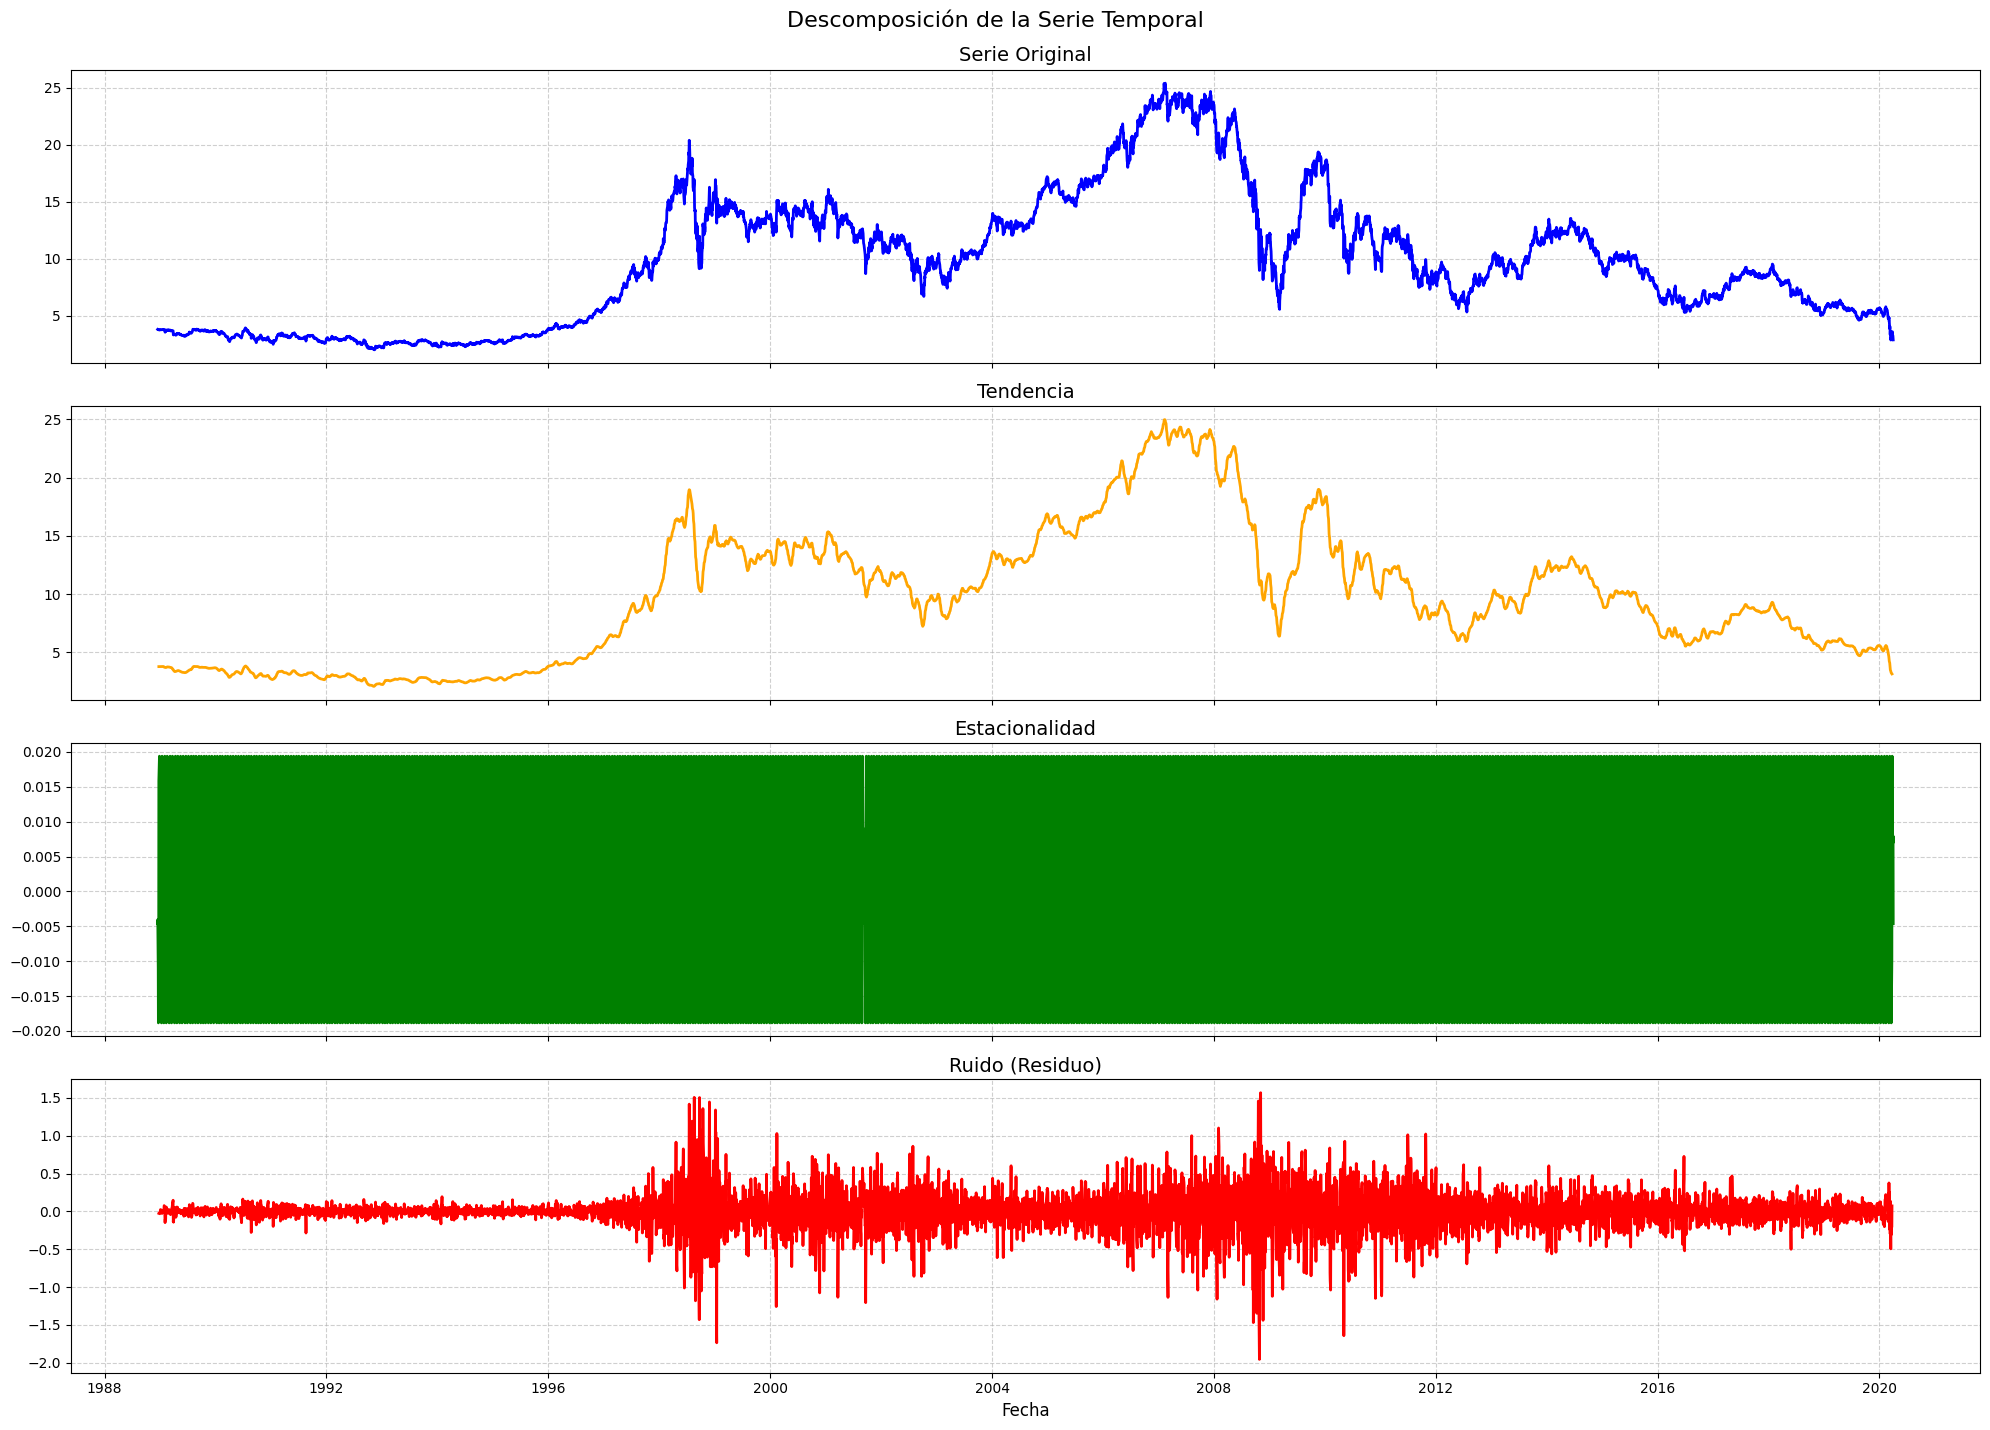

In [103]:
decomposition = seasonal_decompose(df_bb["Close"], model='additive', period=12)

# Crear figura y subplots
fig, axes = plt.subplots(4, 1, figsize= (20, 15), sharex=True)

# Serie original
axes[0].plot(df_bb["Close"], color="blue", linewidth=2)
axes[0].set_title("Serie Original", fontsize=14)
axes[0].grid(visible=True, linestyle="--", alpha=0.6)

# Tendencia
axes[1].plot(decomposition.trend, color="orange", linewidth=2)
axes[1].set_title("Tendencia", fontsize=14)
axes[1].grid(visible=True, linestyle="--", alpha=0.6)

# Estacionalidad
axes[2].plot(decomposition.seasonal, color="green", linewidth=2)
axes[2].set_title("Estacionalidad", fontsize=14)
axes[2].grid(visible=True, linestyle="--", alpha=0.6)

# Ruido
axes[3].plot(decomposition.resid, color="red", linewidth=2)
axes[3].set_title("Ruido (Residuo)", fontsize=14)
axes[3].grid(visible=True, linestyle="--", alpha=0.6)

# Ajustar diseño
plt.suptitle("Descomposición de la Serie Temporal", fontsize=16, y=0.95)
plt.xlabel("Fecha", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Compruebo la Estacionaridad o No estacionaridad analíticamente**

In [104]:

result = adfuller(df_bb["Close"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Valores Críticos:")
for key, value in result[4].items():
    print(f"{key}: {value}")
if result[1] < 0.05:
    print("Rechazamos la hipótesis nula. La serie es estacionaria.")
else:
    print("No podemos rechazar la hipótesis nula. La serie NO es estacionaria.")

ADF Statistic: -1.7580283587639463
p-value: 0.40148939445707965
Valores Críticos:
1%: -3.4311833044118436
5%: -2.861908259874245
10%: -2.5669660201062925
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


### **MODELOS DE SERIES TEMPORALES:**  
  
**SARIMA(X)**  (No funcionan con Tendencias por ello se transforman los datos para que no tengan tendencia (parámetro "d"))
- Cuando los datos sean *estacionales* y haya *tendencia*  
  
  AUTOCORRELACIÓN (El dato siguiente dependerá del anterior)
- Parámetros:  
    - p: nº de valores del pasado que voy a usar para predecir el futuro  SALE DE LA AUTOCORRELACIÓN PARCIAL
    - d(diferenciación): 1 *(Si los patrones de tendencia son muy leves/suaves (usa exponenciales o logaritmicas dependiendo de los datos))* o 2 *(Si los patrones de tendencia son muy claros/abruptos (usa box-post))*
    - q: nº de errores del pasado que vamos a usar para corregir las predicciones del futuro   SALE DE LA AUTOCORRELACIÓN
  
**ARIMA**  
- Cuando los datos sean *NO estacionales* y haya o no *tendencia*  
  
- Parámetros:  
    - p
    - d
    - q  

En nuestro caso concreto usamos el SARIMA

Esta gráfica nos permite identificar patrones de correlaciones entre los datos   
  
**También nos sirve para sacar el parámetro Q**  

<Figure size 1000x3000 with 0 Axes>

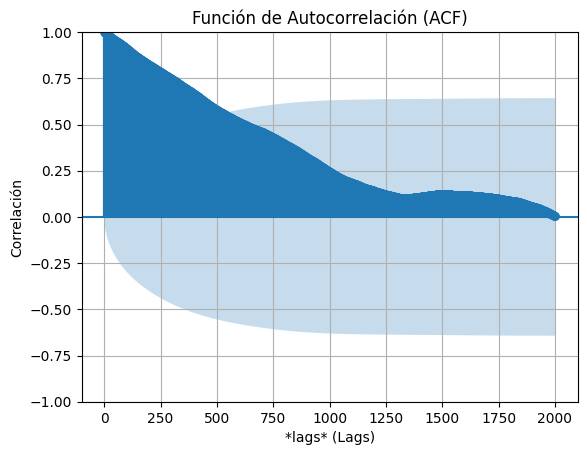

In [108]:
# GRAFICO DE LA AUTOCORRELACIÓN
plt.figure(figsize=(10,30))
plot_acf(df_bb, lags=2000)  
plt.title("Función de Autocorrelación (ACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación")
plt.grid();

***Este gráfico nos muestra como se van correlacionando los datos empezando por si mismo (Ej enero de 2020 va bajando su correlacion con los siguientes meses del año hasta que llega Enero de 2021 que sube la correlación porque es el mismo mes (estos picos no confirman la estacionalidad pero está más bajo por que tiene tendencia))***    
En el lag 1 compara las correlaciones de un salto enero con febrero, febrero con marzo etc  
En el lag 2 compara las correlaciones de dos saltos enero con marzo, febrero con abril etc  
En el lag 3 compara las correlaciones de tres saltos enero con abril, febrero con mayo etc   
....  
En el lag 12 compara las correlaciones de doce saltos enero 2020 con enero 2021, febrero 2020 con febrero 2021 etc (Estos son los picos)    
  

De aquí sacamos que el parámetro Q=500 porque es el periodo estacional (auqnue no sea el último significativo)   

***ESTE GRÁFICO SIRVE PARA DETERMINAR EL PARÁMETRO P***

las sombras son los intervalos de confianzas de que sean 0 es decir si el punto (correlación) está dentro del rango significa que podría ser 0 y por ello no sería sigificativa

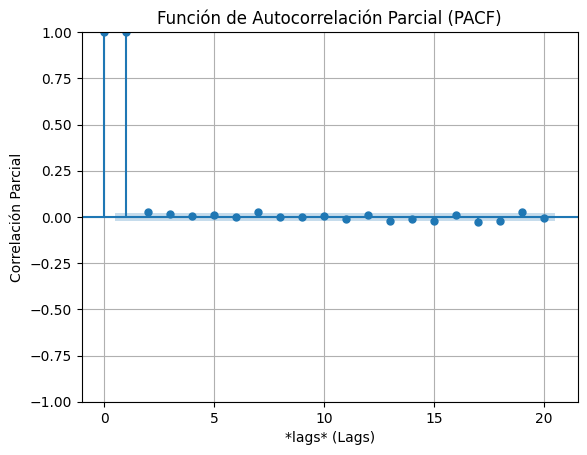

In [115]:
# Graficar la autocorrelación parcial
plot_pacf(df_bb, lags=20, method='ywm')  # Cambia 'method' según tu versión
plt.title("Función de Autocorrelación Parcial (PACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación Parcial")
plt.grid()
plt.show()

Este compara los lags pero en vez de en el lag 12 comparar solo enero 2020 y enero 2021, tiene en cuenta todos los meses que hay entre medias  
  
De aquí sacamos que el parámetro P=1 porque es el último lag consecutivo que es significativo

#### Ahora vamos a separar en Train y Test para entrenar el modelo

In [116]:
datos_en_test=int(np.round(df_bb.shape[0]*0.2, 0))
y_train= df.iloc[:-datos_en_test]
y_test= df.iloc[-datos_en_test:]


El arima no tiene el parametro de estacionalidad

In [117]:
ps= range(4)
qs= range(500)

combinaciones=list(product(ps,qs))


Esto es para sacar nuestro mejor modelo

In [ ]:
model = ARIMA(y_train, order=(1, 1, 500))
model_fit = model.fit()

# Paso 3: Resumen de resultados
print(model_fit.summary())

# Paso 4: Predicciones
# Predicción dentro de la muestra
df_bb['fitted'] = model_fit.fittedvalues

# Predicción fuera de la muestra
forecast_steps = 30  # Número de pasos a predecir
forecast = model_fit.forecast(steps=forecast_steps)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(df_bb.index, df_bb['Close'], label="Valores reales", color='blue')
plt.plot(df_bb.index, df_bb['fitted'], label="Valores ajustados (fitted)", color='green')
plt.plot(pd.date_range(df_bb.index[-1], periods=forecast_steps + 1, freq="D")[1:], 
         forecast, label="Predicciones", color='red')
plt.legend()
plt.title("Modelo ARIMA - Ajuste y Predicción")
plt.show()


Los Stocks no lo he acabado porque me tardaba demasiado y no sé si lo estaba haciendo bien. Lo único que tengo claro es que no son estacionales y por ello no se puede usar sarimax.